# Learnsync ML use case implementation (Simulation version)

In [57]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from matplotlib_venn import venn3
from scipy.stats import shapiro
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

## 1. Prepare data source
- The original dataset we chose from [Time Management and Productivity Insights](https://www.kaggle.com/datasets/hanaksoy/time-management-and-productivity-insights/data) is fictitious. And does not contain relationships between the independent features and the Productivity Level. Thus we decide to generate our own dataset for one of our ML use case `Providing time management tips and learning strategies`.
- The columns in our generated dataset are consistent with the original dataset.

### Generate dataset

In [52]:
def gen_dataset(n_samples=500):
    """
    Input: sample numbers
    Output: dataset in pd.DataFrame format

    Assumption:
    - Factors with positive relationship to productivity:
        daily_work_hours, daily_sleep_hours, exercise_hours, daily_leisure_hours
    - Factors with negative relationship to productivity:
        commute_time, screen_time, age

    The productivity score is generated using a weighted sum of features.
    Each weight reflects how strongly that factor is assumed to influence productivity.
    A small amount of random noise is added to simulate real-world unpredictability.
    """
    import numpy as np
    import pandas as pd

    np.random.seed(42)

    # Generate features
    user_id = np.arange(1, n_samples + 1)
    age = np.random.randint(20, 60, size=n_samples)
    daily_work_hours = np.random.uniform(4, 10, size=n_samples)
    daily_leisure_hours = np.random.uniform(0.5, 5, size=n_samples)
    daily_exercise_minutes = np.random.uniform(0, 120, size=n_samples)
    daily_sleep_hours = np.random.uniform(5, 9, size=n_samples)
    screen_time = np.random.uniform(1, 6, size=n_samples)
    commute_time = np.random.uniform(0, 2, size=n_samples)

    # Convert exercise time to hours
    exercise_hours = daily_exercise_minutes / 60.0

    # Assume the productivity score follows a realistic pattern:
    productivity_score = (
        1.5 * daily_work_hours           # More work hours can increase productivity
        + 1.0 * daily_sleep_hours        # Better sleep supports better focus and output
        + 0.8 * exercise_hours           # Physical activity improves energy and alertness
        + 0.4 * daily_leisure_hours      # Moderate leisure helps reduce stress
        - 0.6 * commute_time             # Longer commutes reduce time and energy for work
        - 0.05 * age                     # Slight decline in productivity with age
        - 0.2 * screen_time              # Excessive screen time may distract or tire users
        + np.random.normal(0, 2, size=n_samples)  # Add some noise to mimic real-life variance
    )

    # Clip productivity score to 0–100 range
    productivity_score = np.clip(productivity_score, 0, 100)

    # Create the final DataFrame
    df = pd.DataFrame({
        'User ID': user_id,
        'Age': age,
        'Daily Work Hours': daily_work_hours,
        'Daily Leisure Hours': daily_leisure_hours,
        'Daily Exercise Minutes': daily_exercise_minutes,
        'Daily Sleep Hours': daily_sleep_hours,
        'Screen Time (hours)': screen_time,
        'Commute Time (hours)': commute_time,
        'Productivity Level': productivity_score
    })

    return df

gen_data = gen_dataset(n_samples=1000)
print(f"Generate {gen_data.shape[0]} data. \nShape of dataframe: {gen_data.shape}.")
display(gen_data.head(5))

Generate 1000 data. 
Shape of dataframe: (1000, 9).


,User ID,Age,Daily Work Hours,Daily Leisure Hours,Daily Exercise Minutes,Daily Sleep Hours,Screen Time (hours),Commute Time (hours),Productivity Level
0,1,58,4.625482,4.740419,116.046322,8.128203,1.593303,0.185057,15.684494
1,2,48,9.042638,4.027292,47.135253,5.960283,1.859383,0.798865,21.034459
2,3,34,9.464117,2.096786,102.506629,5.577237,3.382632,0.837858,19.412948
3,4,27,4.736865,2.354589,92.770685,5.462805,4.689402,1.029124,11.003370
4,5,40,5.415436,2.973272,37.199992,5.109000,1.695011,1.417929,11.806382


### Store dataframe into csv file.

In [47]:
# Save the generated dataset to a CSV file
path = "../data/synthetic_productivity_dataset.csv"
gen_data.to_csv(path, index=False)
print(f"Dataset saved as {path}")

Dataset saved as ../data/synthetic_productivity_dataset.csv


### Load dataset from csv file.

In [70]:
# Create dataset
path = "../data/synthetic_productivity_dataset.csv"
data = pd.read_csv(path)

In [53]:
data.describe()

,User ID,Age,Daily Work Hours,Daily Leisure Hours,Daily Exercise Minutes,Daily Sleep Hours,Screen Time (hours),Commute Time (hours),Productivity Score
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,39.991000,7.018604,2.766710,61.761574,6.928198,3.448654,0.994105,16.148932
std,288.819436,11.780055,1.706972,1.313435,34.053289,1.172415,1.429240,0.575209,3.729774
min,1.000000,20.000000,4.001425,0.500848,0.053134,5.000746,1.010383,0.001255,4.760570
25%,250.750000,30.000000,5.524843,1.586805,33.501551,5.920530,2.200380,0.511140,13.548306
50%,500.500000,41.000000,7.087509,2.855072,62.560355,6.876617,3.438810,1.007427,16.256726
75%,750.250000,50.250000,8.489165,3.881048,91.553651,7.970909,4.685450,1.459618,18.889686
max,1000.000000,59.000000,9.996121,4.998712,119.945270,8.990491,5.995247,1.999698,25.895708


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 1000 non-null   int64  
 1   Age                     1000 non-null   int64  
 2   Daily Work Hours        1000 non-null   float64
 3   Daily Leisure Hours     1000 non-null   float64
 4   Daily Exercise Minutes  1000 non-null   float64
 5   Daily Sleep Hours       1000 non-null   float64
 6   Screen Time (hours)     1000 non-null   float64
 7   Commute Time (hours)    1000 non-null   float64
 8   Productivity Score      1000 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 70.4 KB


### Preprocessing

In [71]:
features = data.drop('User ID', axis=1)
X = features.values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Feature Correlation Heatmap

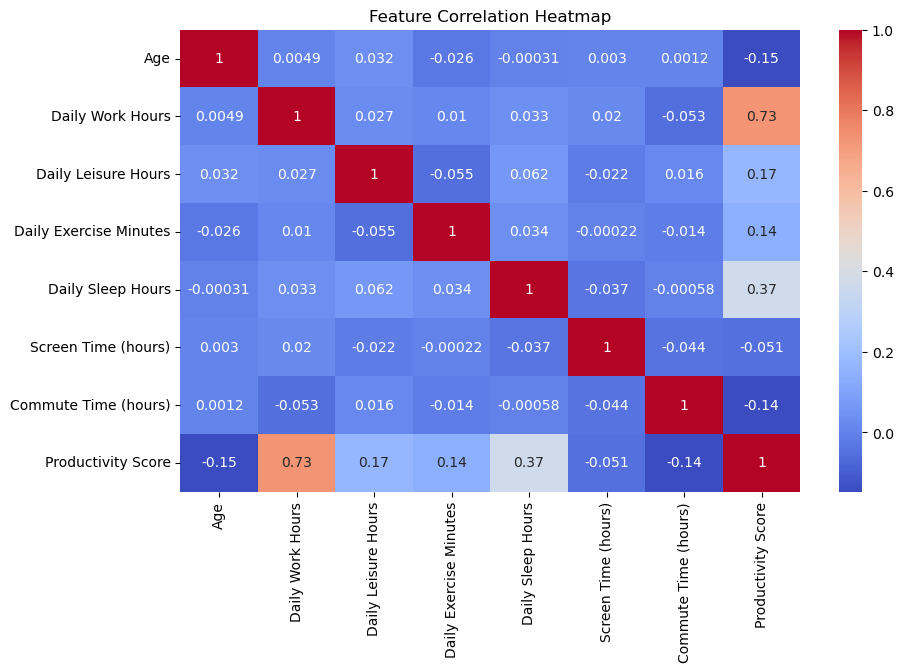

In [73]:
plt.figure(figsize=(10,6))
# sns.heatmap(data[features + ['Productivity Score']].corr(), annot=True, cmap='coolwarm')
sns.heatmap(features.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

## 2. K-Means Clustering

In [58]:
wcss = []
bcss = []
max_clusters = 5
k_range = range(1, max_clusters + 1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # WCSS
    bcss.append(np.sum((kmeans.cluster_centers_ - np.mean(X_scaled, axis=0))**2))  # BCSS

In [59]:
# Calculate TSS and the ratio BCSS / (BCSS + WCSS)
tss = np.array(wcss) + np.array(bcss)
ratio = bcss / tss

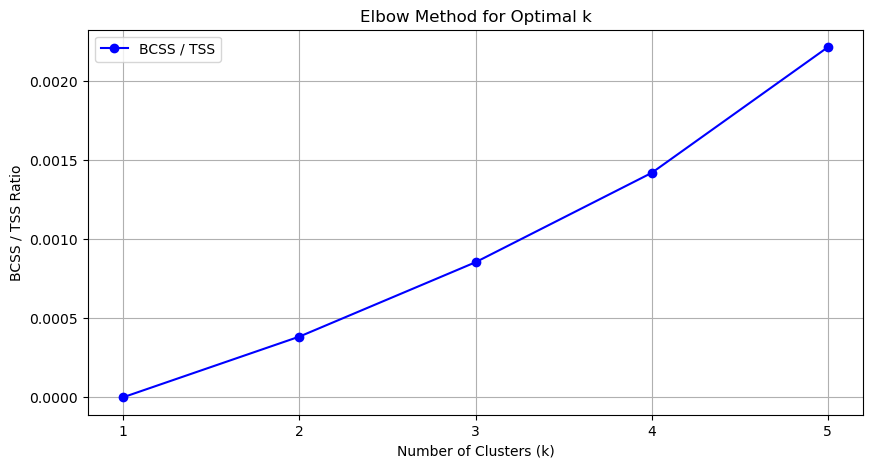

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(k_range, ratio, 'bo-', label='BCSS / TSS')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('BCSS / TSS Ratio')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid()
plt.legend()
plt.show()

In [61]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
data['Cluster'] = clusters

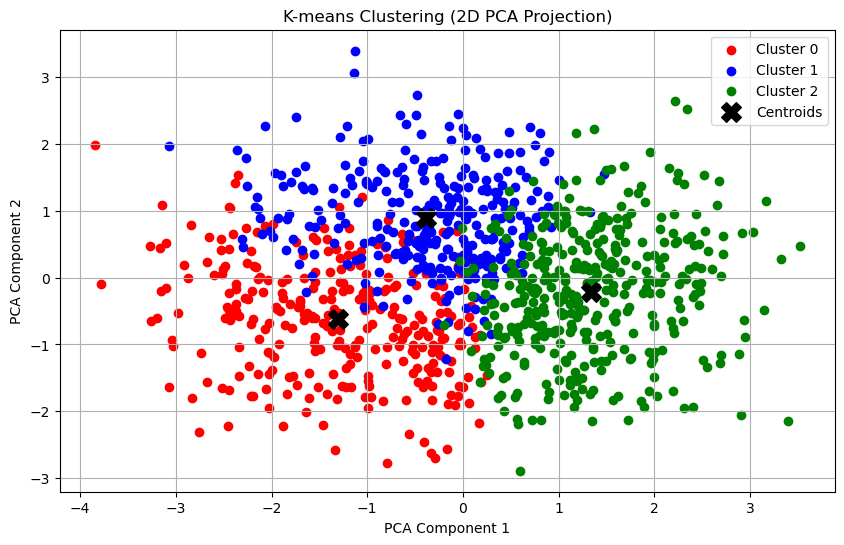

In [62]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green']  # Adjust for k
for i in range(k):
    plt.scatter(X_pca[clusters == i, 0], X_pca[clusters == i, 1], 
                c=colors[i], label=f'Cluster {i}')

# Plot centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            marker='X', s=200, c='black', label='Centroids')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering (2D PCA Projection)')
plt.legend()
plt.grid()
plt.show()

In [63]:
print(data.groupby('Cluster').mean())

            User ID        Age  Daily Work Hours  Daily Leisure Hours  \
Cluster                                                                 
0        496.241042  40.293160          5.877282             1.686817   
1        523.141447  41.187500          6.282088             3.822374   
2        486.167095  38.817481          8.494921             2.793972   

         Daily Exercise Minutes  Daily Sleep Hours  Screen Time (hours)  \
Cluster                                                                   
0                     67.232931           6.333527             3.644496   
1                     47.217113           7.037329             3.274370   
2                     68.809926           7.312228             3.430297   

         Commute Time (hours)  Productivity Score  
Cluster                                            
0                    1.046345           12.785093  
1                    1.159083           15.133640  
2                    0.823949           19.597125 

## 3. Use case: Providing time management tips and learning strategies

– About: This use case aims to provide users with suggestions to improve their time management and learning strategies. Before doing so, the system will analyze key learning-related factors that may significantly influence the user's `Productivity Score`.

– Tasks: The following section performs an `MLR-OLS analysis` to identify the most important factors. Based on this analysis, a regression model will be built to predict each user's `Productivity Score`.

### Split into training and testing set

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Select features
sel_features = ['Age', 'Daily Work Hours', 'Daily Leisure Hours', 'Daily Exercise Minutes',
            'Daily Sleep Hours', 'Screen Time (hours)', 'Commute Time (hours)']
X = data[sel_features]
y = data['Productivity Score']

# Prepare Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Conduct Z-scaled normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # Fit on training data
X_test_scaled = scaler.transform(X_test)         # Transform test data using training stats

### 3.1 OLS analysis

In [75]:
X = sm.add_constant(X_train_scaled) # Add intercept
model = sm.OLS(y_train, X).fit() # Build MLR model
print(model.summary()) # Print result

                            OLS Regression Results                            
Dep. Variable:     Productivity Score   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     278.4
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          1.23e-208
Time:                        22:15:43   Log-Likelihood:                -1682.4
No. Observations:                 800   AIC:                             3381.
Df Residuals:                     792   BIC:                             3418.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1717      0.070    229.640      0.0

### 3.2 MLR: Multi-input regression task

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create and train regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict the Productivity Score on testing set
y_pred = model.predict(X_test_scaled)

# Evluate model by testing results
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print(f"MSE: {mse:.2f}")
print(f"R_square: {r2:.2f}")

# Print model coefficients
coefficients = pd.DataFrame({
    'Feature': sel_features,
    'Coefficient': model.coef_
})
print(coefficients.sort_values(by='Coefficient', ascending=False))

MSE: 3.62
R_square: 0.76
                  Feature  Coefficient
1        Daily Work Hours     2.579189
4       Daily Sleep Hours     1.214959
2     Daily Leisure Hours     0.508517
3  Daily Exercise Minutes     0.479787
5     Screen Time (hours)    -0.187482
6    Commute Time (hours)    -0.388894
0                     Age    -0.551266


## Summary
In this document, multi-linear regression model is able to predict the productivity score of the generated dataset.